In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torch.autograd.variable as Variable
from torchvision import transforms

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])
train_set=torchvision.datasets.MNIST(root='./MNIST_data/train',train=True,transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True,num_workers=4)

test_set=torchvision.datasets.MNIST(root='./MNIST_data/test',train=False,transform=transform,download=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True,num_workers=4)

In [15]:
device

device(type='cuda')

In [16]:
images,label=next(iter(test_loader))
images.size()

torch.Size([64, 1, 28, 28])

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
         
        self.localization=nn.Sequential(nn.Conv2d(1,8,kernel_size=7),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(True),
                                        nn.Conv2d(8,10,kernel_size=5),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(True))
        self.fc_loc=nn.Sequential(nn.Linear(10*3*3,32),
                                  nn.ReLU(True),
                                  nn.Linear(32,3*2))
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0]))
        
    def stn(self,x):
        xs=self.localization(x)
        xs=xs.view(-1,10*3*3)
        theta=self.fc_loc(xs)
        theta=theta.view(-1,2,3)
        grid=F.affine_grid(theta,x.size())
        x=F.grid_sample(x,grid)
        return x
    def forward(self,x):
        x=self.stn(x)
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320)
        x=self.fc1(x)
        x=F.relu(x)
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)
    
net=Net().to(device)
        

In [18]:
images,target=next(iter(train_loader))



In [19]:
optimizer=optim.SGD(net.parameters(),lr=0.01)
def train(epoch):
    net.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output=net(data)
        loss=F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        net.eval()
        test_loss=0
        correct=0
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=net(data)
            test_loss+=F.nll_loss(output,target,size_average=False).item()
            pred=output.max(1,keepdim=True)[1]
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))    

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.446827
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.230990

Test set: Average loss: 0.1366, Accuracy: 9725/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.283782
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.139395

Test set: Average loss: 0.1083, Accuracy: 9770/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.215616
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.118099

Test set: Average loss: 0.1102, Accuracy: 9709/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.164936
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.144927

Test set: Average loss: 0.0654, Accuracy: 9853/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.186097
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.059566

Test set: Average loss: 0.0543, Accuracy: 9869/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.037991
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.104196

Test set: Average loss: 0.0578, Accuracy: 9844/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.103560
Train Epoch: 7 [320

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f305fcbc2e8>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File 

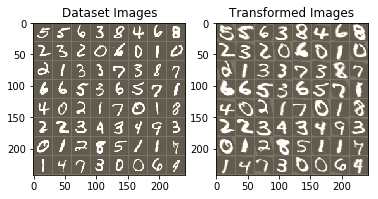

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

def convert_image_np(image):
    img=image.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img=img*std+mean
    img=np.clip(img,0,1)
    return img

def visualize():
    with torch.no_grad():
        data=next(iter(test_loader))[0].to(device)
        input=data
        transformed_input=net.stn(input)
        in_grid=convert_image_np(torchvision.utils.make_grid(input.cpu()))
        out_grid=convert_image_np(torchvision.utils.make_grid(transformed_input.cpu()))
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1,20):
    train(epoch)
    test()

visualize()    
plt.ioff()
plt.show()
